In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import math 
import csv
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")

# read in data

In [2]:
def combine_dataframes(directory, ext, pop, sep="\t"): 
    df_list = []
    
    for i in range(1, 23): 
        df = pd.read_csv(f"{directory}/{pop}_{i}{ext}", sep=sep)
        df_list.append(df)
        
    return pd.concat(df_list)

In [3]:
def return_frequency(directory, ext, pop): 
    
    frq = combine_dataframes(directory, ext, pop)
        
    frq["cluster_size"] = frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"]
    frq["name"] = frq["ID"] + "_" + frq["#CHROM"].astype(str)
    frq["maf"] = (frq["TWO_ALT_GENO_CTS"] + (frq["HET_REF_ALT_CTS"]/2))/(frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"] + frq["HOM_REF_CT"] )
    
    return frq

In [4]:
def return_assoc(directory, ext, pop): 
    
    assoc = combine_dataframes(directory, ext, pop, " ")
    assoc["name"] = assoc["ID"] + "_" + assoc["CHROM"].astype(str)
    assoc = assoc.dropna(subset=["LOG10P.Y1"])

    return assoc

In [5]:
def perform_qc(assoc, frq, min_hom_count=3, max_frq_maf=0.05, std_thresh=3, qc_type="all"): 
    
    min_hom = frq[frq["TWO_ALT_GENO_CTS"] >= min_hom_count]["name"].values
    max_frq = frq[frq["maf"] < 0.05]["name"].values 
    
    mean, std = frq["cluster_size"].mean(), frq["cluster_size"].std()
    cluster_sharing = set(frq[frq["cluster_size"] <= (std_thresh*std) + mean]["name"].values).intersection(min_hom)
    
    all_intersection = set(cluster_sharing).intersection(set(min_hom)).intersection(set(max_frq))
    
    qc_type_dict = {"maf":max_frq, "min_hom":min_hom, "cluster_sharing":cluster_sharing,
                    "all":all_intersection}
    
    return assoc[assoc["name"].isin(qc_type_dict[qc_type])], qc_type_dict

In [6]:
def multiple_test_correction(df, phenotype_num, test_type="bonferroni"): 
    
    df["P"] = 10**(-df[f"LOG10P.Y{phenotype_num}"])
    
    df[test_type] = multipletests(df["P"], method=test_type)[0]
    df["-log P"] = -(np.log10(df["P"]))

### make dataframes

In [21]:
directory = "all_phenotypes_binary/phecodes/pr/regenie/icurl/"
ext = "_BI_168.211"
pop="pr"

assoc = return_assoc(directory, f"{ext}.regenie", pop)
frq = return_frequency(directory, ".gcount", pop)
case_frq = return_frequency(directory, f"{ext}_case.gcount", pop)

# qc 

### run QC 

In [23]:
assoc_qc, qc_dict = perform_qc(assoc, frq, qc_type="min_hom", std_thresh=3, min_hom_count=3, max_frq_maf=0.01)

In [24]:
len(qc_dict["maf"]), len(qc_dict["min_hom"]), len(qc_dict["cluster_sharing"]), len(qc_dict["all"])

(3798801, 6678, 649, 649)

In [25]:
# assoc_qc = assoc_qc[assoc_qc["OR"] >= 1]

In [26]:
multiple_test_correction(assoc_qc, 1)

In [27]:
# assoc_qc = assoc_qc[assoc_qc["BETA.Y2"] >= 0]

# plots

### P value histogram 

In [32]:
# sns.histplot(x="P", data=assoc_qc, color="#9B97B2")
# plt.show()

### QQ plot

In [31]:
# qqplot(data=assoc_qc["P"], color="#73A6AD", alpha=1)
# sns.despine()
# plt.show()

### manhattan plot

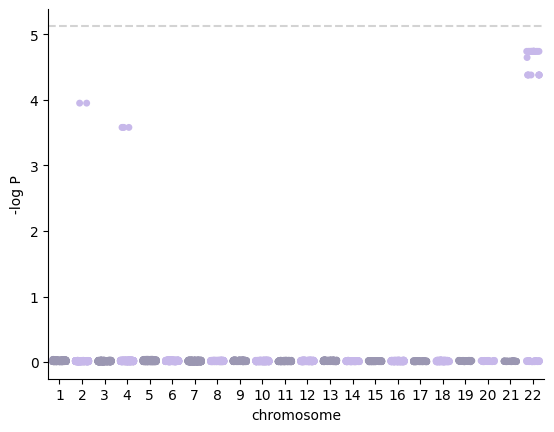

In [30]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(assoc_qc))

sns.stripplot(x="CHROM", y="-log P", data=assoc_qc, order=order, jitter=0.3, 
               palette=sns.color_palette(["#9B97B2", "#C7B8EA"]*11))

plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()

In [49]:
assoc_qc.sort_values(by="P").head(n=20)


,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA.Y1,SE.Y1,...,LOG10P.Y1,BETA.Y2,SE.Y2,CHISQ.Y2,LOG10P.Y2,EXTRA,name,P,bonferroni,-log P
3544,22,57000000,c192495_22,1,2,0.006076,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c192495_22_22,0.000301,True,3.52175
3526,22,56750000,c190729_22,1,2,0.006012,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c190729_22_22,0.000301,True,3.52175
3503,22,56500000,c186882_22,1,2,0.006140,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c186882_22_22,0.000301,True,3.52175
3503,5,56500000,c186882_5,1,2,0.006140,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c186882_5_5,0.000301,True,3.52175
3526,5,56750000,c190729_5,1,2,0.006012,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c190729_5_5,0.000301,True,3.52175
3544,5,57000000,c192495_5,1,2,0.006076,7818,REC,4.98234,1.21857,...,3.06513,5.77836,1.28637,13.0655,3.52175,NaN,c192495_5_5,0.000301,True,3.52175
5102,4,71000000,c324994_4,1,2,0.007675,7818,REC,5.96829,1.22652,...,5.43876,5.65665,1.34616,12.2148,3.32410,NaN,c324994_4_4,0.000474,True,3.32410
5170,4,71750000,c328989_4,1,2,0.006843,7818,REC,5.96829,1.22652,...,5.43876,5.65665,1.34616,12.2148,3.32410,NaN,c328989_4_4,0.000474,True,3.32410
5308,4,73750000,c336013_4,1,2,0.006523,7818,REC,5.96829,1.22652,...,5.43876,5.65665,1.34616,12.2148,3.32410,NaN,c336013_4_4,0.000474,True,3.32410
5295,4,73500000,c335467_4,1,2,0.006587,7818,REC,5.96829,1.22652,...,5.43876,5.65665,1.34616,12.2148,3.32410,NaN,c335467_4_4,0.000474,True,3.32410


In [32]:
map_file = pd.read_csv("icurl/libd/pr_only/redone/cluster2_4.map", sep=" ", header=None)
frq_file = pd.read_csv("comparison/cirrhosis/regenie/icurl/cluster2_4.gcount", sep="\t")
case_frq_file = pd.read_csv("comparison/cirrhosis/regenie/icurl/cluster2_4_case.gcount", sep="\t")
map_file["size"] = map_file[3] - map_file[2]
map_file["region"] = "chr" + map_file[0].astype(str) + ":" + map_file[2].astype(str) + "-" + map_file[3].astype(str)

In [37]:
snp = "c328989_4"

In [38]:
frq_file[frq_file["ID"] == snp]

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
102920,4,c328989_4,1,2,Y,7756,101,3,0,0,0


In [39]:
case_frq_file[case_frq_file["ID"] == snp]

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
102920,4,c328989_4,1,2,Y,41,1,2,0,0,0


In [41]:
map_file[map_file[1] == snp ]

,0,1,2,3,size,region
67428,4,c328989_4,71500001,71750000,249999,chr4:71500001-71750000


In [202]:
geno = pd.read_csv("comparison/height/dashcc/cluster2_1.raw", sep=" ")

In [203]:
pheno = pd.read_csv("output_regenie/cluster2/height_pheno.txt", sep="\t")

In [204]:
geno_pheno = geno.merge(pheno, on="FID") 

In [205]:
geno_pheno.head()

,FID,IID_x,PAT,MAT,SEX,PHENOTYPE,cs39060_2,cs6980_2,cs60944_2,IID_y,height
0,1000040,1000040,0,0,0,-0.180150,0,0,0,1000040,67.0
1,1002881,1002881,0,0,0,-0.519585,1,1,1,1002881,66.0
2,1002900,1002900,0,0,0,0.015992,0,0,0,1002900,61.0
3,1003192,1003192,0,0,0,-1.062340,0,0,0,1003192,60.0
4,10037115,10037115,0,0,0,-0.180150,0,0,0,10037115,67.0


In [206]:
geno_pheno[f"{snp}_2"].value_counts()

cs60944_2
0    5854
1     300
2       3
Name: count, dtype: int64

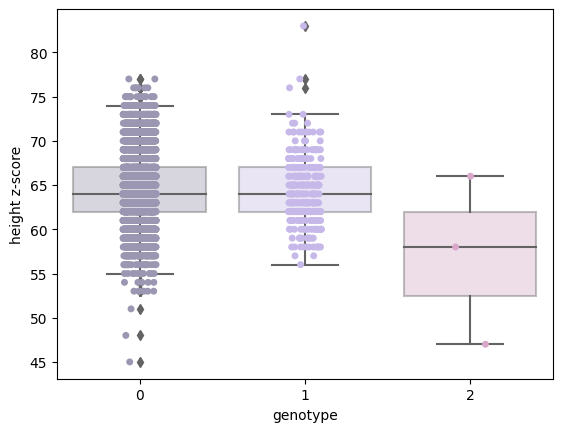

In [207]:
sns.boxplot(x=f"{snp}_2", y="height", data=geno_pheno, boxprops=dict(alpha=0.4),
            palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
sns.stripplot(x=f"{snp}_2", y="height", data=geno_pheno, alpha=1,
             palette=sns.color_palette(["#9B97B2", "#C7B8EA", "#D8A7CA"]))
plt.xlabel("genotype")
plt.ylabel("height z-score")
plt.show() 